<a href="https://colab.research.google.com/github/Pankhuri33/House-Price-Prediction-Model/blob/main/HousePrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
df = pd.read_csv("banglore.csv")
df.head()


,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


In [2]:
df.shape
df.info()
df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13320 entries, 0 to 13319
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   area_type     13320 non-null  object 
 1   availability  13320 non-null  object 
 2   location      13319 non-null  object 
 3   size          13304 non-null  object 
 4   society       7818 non-null   object 
 5   total_sqft    13320 non-null  object 
 6   bath          13247 non-null  float64
 7   balcony       12711 non-null  float64
 8   price         13320 non-null  float64
dtypes: float64(3), object(6)
memory usage: 936.7+ KB


,bath,balcony,price
count,13247.000000,12711.000000,13320.000000
mean,2.692610,1.584376,112.565627
std,1.341458,0.817263,148.971674
min,1.000000,0.000000,8.000000
25%,2.000000,1.000000,50.000000
50%,2.000000,2.000000,72.000000
75%,3.000000,2.000000,120.000000
max,40.000000,3.000000,3600.000000


The dataset contains both numerical and categorical features requiring preprocessing and feature engineering.

In [3]:
df.drop('society', axis=1, inplace=True)


In [4]:
df.drop('availability', axis=1, inplace=True)

Availability information does not significantly impact price prediction and was removed to reduce noise.

In [5]:
df.isnull().sum()

,0
area_type,0
location,1
size,16
total_sqft,0
bath,73
balcony,609
price,0


In [6]:
df.dropna(subset=['size', 'bath'], inplace=True)
df['balcony'].fillna(df['balcony'].median(), inplace=True)

/tmp/ipython-input-1743254781.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['balcony'].fillna(df['balcony'].median(), inplace=True)


In [7]:
df['bhk'] = df['size'].apply(lambda x: int(x.split(' ')[0]))
df.drop('size', axis=1, inplace=True)

In [8]:
def convert_sqft_to_num(x):
    tokens = x.split('-')
    if len(tokens) == 2:
        return (float(tokens[0]) + float(tokens[1])) / 2
    try:
        return float(x)
    except:
        return None

df['total_sqft'] = df['total_sqft'].apply(convert_sqft_to_num)
df.dropna(subset=['total_sqft'], inplace=True)


In [9]:
df['price_per_sqft'] = (df['price'] * 100000) / df['total_sqft']

In [11]:
df['location'] = df['location'].fillna('Unknown')
location_stats = df['location'].value_counts()
df['location'] = df['location'].apply(
    lambda x: 'Other' if location_stats[x] <= 10 else x
)


Exploratory Data Analysis

<Axes: xlabel='total_sqft', ylabel='price'>

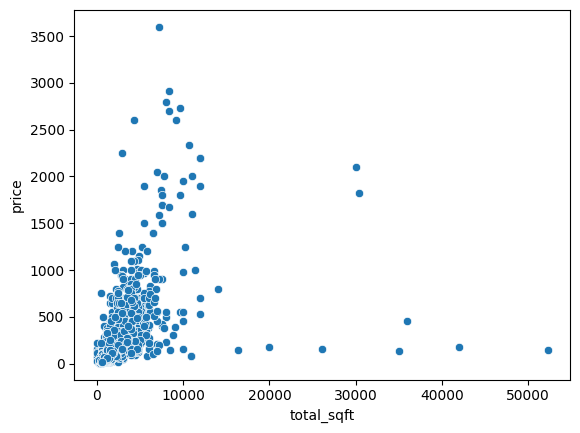

In [12]:
import seaborn as sns
sns.scatterplot(x='total_sqft', y='price', data=df)

<Axes: xlabel='bhk', ylabel='price'>

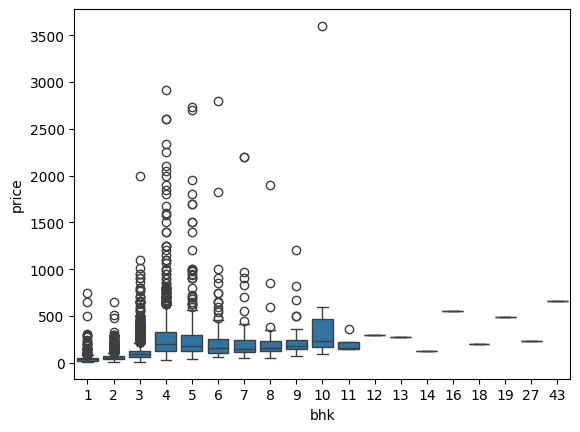

In [13]:
sns.boxplot(x='bhk', y='price', data=df)

In [14]:
df.groupby('location')['price'].mean().sort_values(ascending=False).head(10)

,price
location,
Cunningham Road,824.384615
Kodihalli,367.733333
Malleshwaram,359.408772
Benson Town,346.743333
HAL 2nd Stage,339.272727
Bommenahalli,328.727273
Rajaji Nagar,326.779811
Mahalakshmi Layout,294.846154
Indira Nagar,286.318182


EDA revealed strong correlation between area, location, and price.

In [15]:
df = df[df['total_sqft'] / df['bhk'] >= 300]

In [16]:
df = df[df['price_per_sqft'] < df['price_per_sqft'].quantile(0.99)]

Encode Categorical Variables

In [17]:
df = pd.get_dummies(df, drop_first=True)

In [18]:
from sklearn.model_selection import train_test_split

X = df.drop('price', axis=1)
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


Linear Regression

In [19]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred_lr = lr.predict(X_test)

In [20]:
from sklearn.metrics import r2_score
r2_score(y_test, y_pred_lr)

0.7985548708580875

Random Forest Regressor

In [21]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
r2_score(y_test, y_pred_rf)


0.9935158451017796

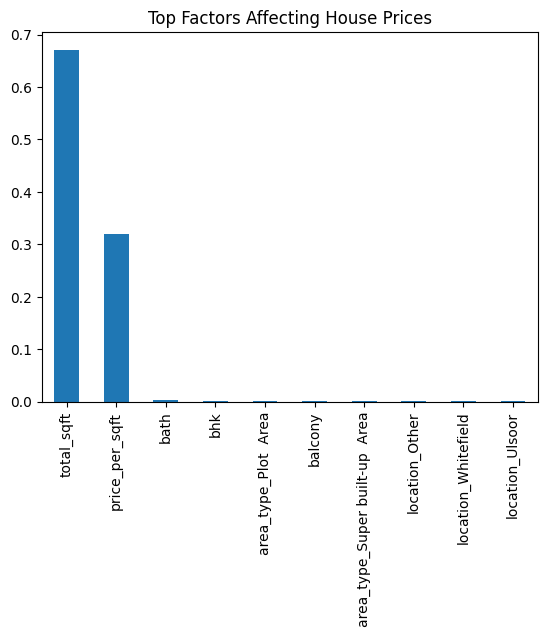

In [22]:
import matplotlib.pyplot as plt

importance = pd.Series(
    rf.feature_importances_, index=X.columns
).sort_values(ascending=False)

importance.head(10).plot(kind='bar')
plt.title("Top Factors Affecting House Prices")
plt.show()

Random Forest captured non-linear relationships better and outperformed Linear Regression.

INSIGHTS TO NOTICE AFTER THE PREDICTION

1. Total square feet is the strongest predictor

2. Location significantly affects price

3. Bathrooms have more impact than balconies